# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [3]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357258 sha256=0480e95e546bcc5e3149b780b7b8b15775d4d190f96968f60b7a605a3e171822
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [4]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**

***Import the Dataset***

In [5]:
# import dataset from my Google Drive destination
df = pd.read_csv('/content/drive/MyDrive/Recommendation Systems/Amazon Product Recommendation System/ratings_Electronics.csv')

***Add column names ['user_id', 'prod_id', 'rating', 'timestamp']***

In [6]:
# Add column names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Display the first few rows to verify
df.head()

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


***Drop the column timestamp***

In [7]:
# Drop the 'timestamp' column
df = df.drop(columns=['timestamp'])

# Display the first few rows to verify
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


***Copy the data to another DataFrame called df_copy***

In [8]:
# Copy the data to another DataFrame
df_copy = df.copy()

# Display the first few rows of the copied DataFrame to verify
df_copy.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [9]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [10]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [11]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [12]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [13]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [14]:
# Check the number of rows and columns in the final DataFrame (df_final)
rows, columns = df_final.shape
print(f'The dataset contains {rows} rows and {columns} columns.')

The dataset contains 65290 rows and 3 columns.


####Observations:
- The dataset contains 65,290 rows. This is the ratings given by users who have rated at least 50 products and products that have received at least 5 ratings.
- The dataset has 3 columns:
	- user_id: identifier of a user.
	- prod_id: identifier of a product.
	- rating: Rating given by the user

### **Data types**

In [15]:
# Check data types of the columns
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

#### Observations:
- user_id (object): The user_id is of type object, user IDs are typically alphanumeric identifiers, which should be fine here.
- prod_id (object): The prod_id is also of type object, same thing applies here where the identifier might contain both letters and numbers.
- rating (float64): The rating is of type float64, which is good for numerical ratings including decimal points.


### **Checking for missing values**

In [16]:
# Get a summary of the DataFrame, including non-null counts and data types
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [17]:
# Check for missing values in the dataset
missing_values = df_final.isnull().sum()
missing_values

user_id    0
prod_id    0
rating     0
dtype: int64

#### Observations:
- The user_id column has 65,290 non-null entries.
- The prod_id column has 65,290 non-null entries.
- The rating column has 65,290 non-null entries.

- There are no missing values in any of the columns.

### **Summary Statistics**

In [18]:
# Summary statistics of the 'rating' variable
rating_summary = df_final['rating'].describe()
rating_summary

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

#### Observations:
- Count: 65,290 ratings in the dataset.
- Mean: The average rating is approximately 4.29.
- Standard Deviation (std): The standard deviation is approximately 0.99.
- Minimum (min): The lowest rating is 1.0.
- 25th Percentile (25%): Is 4.0, meaning that 25% of the ratings are 4.0 or below.
- Median (50%): Is 5.0, meaning that at least half of the ratings are 5.0.
- 75th Percentile (75%): Is 5.0, meaning that 75% of the ratings are 5.0 or below.
- Maximum (max): The highest rating is 5.0.

-	The majority of the ratings are very high (4 or 5)


### **Checking the rating distribution**

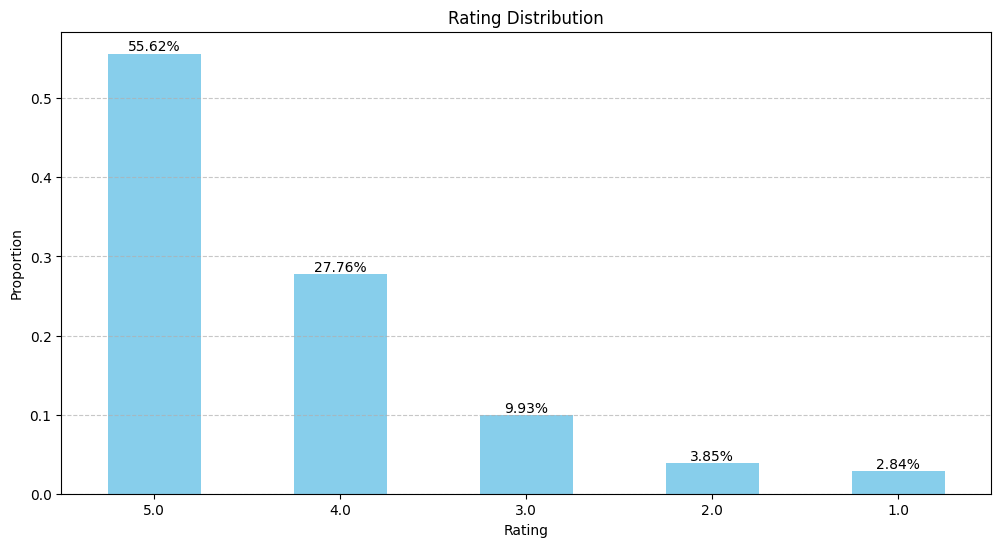

In [19]:
# Set the figure size for the plot
plt.figure(figsize=(12, 6))
# Calculate the value counts and proportions
rating_counts = df_final['rating'].value_counts(normalize=True)

# Plot the distribution of ratings as a bar plot
rating_counts.plot(kind='bar', color='skyblue')

# better visualization here
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the percentage value
for i, value in enumerate(rating_counts):
    plt.text(i, value, f'{value:.2%}', ha='center', va='bottom')

# Display the plot
plt.show()

#### Observations:
- High Ratings:
	- 55.62% of the ratings are 5.
	- 27.76% of the ratings are 4.
	- over 83% of the ratings are 4 or higher, indicating high user satisfaction.
- Moderate Ratings:
	- 9.93% of the ratings are 3
- Low Ratings:
	- 3.85% of the ratings are 2.
	- 2.84% of the ratings are 1.
	- Low ratings (1 and 2) are about 6.69% of the total ratings.

- Positive Skew: The distribution is positively skewed, with a larger number of higher ratings.



### **Checking the number of unique users and items in the dataset**

In [20]:
# Number of total rows in the data and number of unique user id and product id in the data

print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in final data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in final data = ', df_final['prod_id'].nunique())

The number of observations in the final data =  65290
Number of unique USERS in final data =  1540
Number of unique ITEMS in final data =  5689


#### Observations:
- Number of Observations:
	- The dataset contains 65,290 ratings.
- Number of Unique Users:
	- There are 1,540 unique users in the dataset. (Users who rated at least 50 products).
- Number of Unique Items:
	- There are 5,689 unique items in the dataset. (Products that have received at least 5 ratings).


### **Users with the most number of ratings**

In [21]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

#### Observations:

- Top User: The user with the most ratings (ADLVFFE4VBT8) has given 295 ratings.
- Other Top Users: The  top users provided a significant number of ratings, ranging from 179 to 230 ratings each.
- These users are highly active and engaged with the platform.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [22]:
# Calculate the average rating for each product
product_mean_ratings = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
product_rating_counts = df_final.groupby('prod_id')['rating'].count()

# Combine the mean ratings and rating counts into a single DataFrame
product_ranking = pd.DataFrame({
    'mean_rating': product_mean_ratings,
    'rating_count': product_rating_counts
}).reset_index()

# Sort the dataframe by average of ratings in descending order
top_products = product_ranking.sort_values(by='mean_rating', ascending=False)

# Display the top 10 products
top_products.head(10)

,prod_id,mean_rating,rating_count
5688,B00LGQ6HL8,5.0,5
2302,B003DZJQQI,5.0,14
3443,B005FDXF2C,5.0,7
5554,B00I6CVPVC,5.0,7
4810,B00B9KOCYA,5.0,8
2286,B003CK10DG,5.0,5
2266,B003B41XYO,5.0,5
433,B0007WK8KS,5.0,6
4194,B0084FM5JC,5.0,5
3467,B005GI2VMG,5.0,10


In [23]:
### Get the top n products based on the highest average rating and a minimum number of interactions.
def get_top_n_products(final_rating, n, min_interactions):


    # Filter products based on the minimum number of interactions
    filtered_products = final_rating[final_rating['rating_count'] >= min_interactions]

    # Sort the filtered products by average rating in descending order
    top_products = filtered_products.sort_values(by='mean_rating', ascending=False)

    # Return the top n products
    return top_products.head(n)

# Get the top 10 products with at least 50 ratings
top_10_products = get_top_n_products(product_ranking, n=10, min_interactions=50)
print(top_10_products)

         prod_id  mean_rating  rating_count
1594  B001TH7GUU     4.871795            78
2316  B003ES5ZUU     4.864130           184
1227  B0019EHU8G     4.855556            90
3877  B006W8U2MU     4.824561            57
850   B000QUUFRW     4.809524            84
673   B000HPV3RW     4.803922            51
1590  B001TH7GSW     4.803279            61
529   B000BQ7GW8     4.777778            54
781   B000N99BBC     4.772455           167
2073  B002WE6D44     4.770000           100


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [24]:
# Get the top 5 products with at least 50 ratings
top_5_products = get_top_n_products(product_ranking, n=5, min_interactions=50)

# Display the top 5 products
print(top_5_products)

         prod_id  mean_rating  rating_count
1594  B001TH7GUU     4.871795            78
2316  B003ES5ZUU     4.864130           184
1227  B0019EHU8G     4.855556            90
3877  B006W8U2MU     4.824561            57
850   B000QUUFRW     4.809524            84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [25]:
# Get the top 5 products with at least 100 ratings
top_5_products_100_interactions = get_top_n_products(product_ranking, n=5, min_interactions=100)

# Display the top 5 products
print(top_5_products_100_interactions)

         prod_id  mean_rating  rating_count
2316  B003ES5ZUU     4.864130           184
781   B000N99BBC     4.772455           167
2073  B002WE6D44     4.770000           100
4126  B007WTAJTO     4.701220           164
2041  B002V88HFE     4.698113           106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [26]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [27]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [28]:
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


In [29]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [30]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': True  # compute similarities between users
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model, k=10, threshold=3.5)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


#### Observations:

- The RMSE (Root Mean Squared Error) is 1.0012. It is the average difference between the predicted ratings and the actual ratings.
  
- The precision@k is 0.855. This is the proportion of recommended items that are actually relevant. The model is good at recommending relevant items.

- The recall@k is 0.858. This measures the proportion of relevant items that are recommended to the user. The model is effective at capturing most of the relevant items.

- The F1 score@k is 0.856. The model is effective at recommending relevant items while minimizing irrelevant recommendations.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [31]:
# Predicting rating for a sample user with an interacted product
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Predict the rating
predicted_rating = model.predict(uid=user_id, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}')

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 3.4


#### Observations:

- Predicted Rating:
	- The model predicted a rating of 3.4 for the user A3LDPF5FMB782Z and the product 1400501466.

- Actual Rating:
	- The actual rating given by the user for this product is 5. The predicted rating is lower than the actual rating.

- The predicted rating of 3.4 is below the threshold of 3.5, which we set for considering items as recommended. According to this model the product will not be recommended to the user.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [32]:
# Find unique user_id where prod_id is not equal to "1400501466"
unseen_users = df_final[df_final['prod_id'] != '1400501466']['user_id'].unique()

# Check if the user "A34BZM6S9L7QI4" is in the list
user_to_check = 'A34BZM6S9L7QI4'
is_user_present = user_to_check in unseen_users

# Display the first few entries to verify
print(f'Is user {user_to_check} in the list? {is_user_present}')
print('First 10 users who have not seen the product:')
for user in unseen_users[:10]:
    print(user)

if is_user_present:
    index = list(unseen_users).index(user_to_check)
    print(f'User {user_to_check} is at position {index + 1} in the list.')

Is user A34BZM6S9L7QI4 in the list? True
First 10 users who have not seen the product:
A2ZR3YTMEEIIZ4
A3CLWR1UUZT6TG
A5JLAU2ARJ0BO
A1P4XD7IORSEFN
A341HCMGNZCBIT
A3HPCRD9RX351S
A1DQHS7MOVYYYA
ALUNVOQRXOZIA
A19N3S7CBSU6O7
A3G7BEJJCPD6DS
User A34BZM6S9L7QI4 is at position 1403 in the list.


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [33]:
# Predicting rating for a sample user with a non-interacted product
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Predict the rating
predicted_rating = model.predict(uid=user_id, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}')

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.292024046561495


#### Observations:

- The model predicted a rating of approximately 4.29 for the user A34BZM6S9L7QI4 for the product 1400501466.

- A predicted rating of 4.29 indicates that the model expects the user to have a high level of satisfaction with the product without any previous interaction.

- 4.29 is above the threshold of 3.5, this product would be recommended to the user according to the model.



### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [34]:
# Set up the parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40, 50],
    'min_k': [1, 2, 3, 4],  # Minimum number of neighbors to take into account for aggregation
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],  # Similarity measures
        'user_based': [True]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print('Best RMSE score:', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best parameters:', gs.best_params['rmse'])

Best RMSE score: 0.9710031428923088
Best parameters: {'k': 50, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True}}


#### Observations:

- The best RMSE score achieved during the hyperparameter tuning is approximately 0.97.

- Best Hyperparameters:
	- k: 50
	- min_k: 4
	- sim_options: {'name': 'cosine', 'user_based': True} (Using cosine similarity for user-based collaborative filtering)


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [35]:
# Creating an instance of KNNBasic with optimal hyperparameter values
optimal_params = {
    'k': 50,
    'min_k': 4,
    'sim_options': {'name': 'cosine', 'user_based': True}
}
final_model = KNNBasic(k=optimal_params['k'], min_k=optimal_params['min_k'],
                       sim_options=optimal_params['sim_options'], verbose=False, random_state=1)

# Training the algorithm on the trainset
final_model.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(final_model, k=10, threshold=3.5)

RMSE: 0.9511
Precision:  0.852
Recall:  0.889
F_1 score:  0.87


#### Observations:

- The RMSE is 0.9511. This is an improvement over the previous RMSE of 1.0012.

- The precision@k is 0.852. This is slightly lower than the precision of 0.855 obtained before hyperparameter tuning, but it is still high.

- The recall@k is 0.889. This has improved from the previous recall of 0.858, indicating that the model is better at capturing relevant items after tuning.

- The F1 score@k is 0.87. This is an improvement over the previous F1 score of 0.856, indicating a better balance between precision and recall.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [36]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Predict the rating
predicted_rating_optimized_interacted = final_model.predict(uid=user_id, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id} and product {product_id} using the optimized model: {predicted_rating_optimized_interacted.est}')

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized model: 3.4


In [37]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id_non_interacted = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Predict the rating
predicted_rating_optimized_non_interacted = final_model.predict(uid=user_id_non_interacted, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id_non_interacted} and product {product_id} using the optimized model: {predicted_rating_optimized_non_interacted.est}')

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized model: 4.292024046561495


#### Observations:

- For user A3LDPF5FMB782Z and product 1400501466 (interacted): 3.4

- For user A34BZM6S9L7QI4 and product 1400501466 (non-interacted): 4.292


<br>
##### Comparison with Baseline Model Predictions:

- For user A3LDPF5FMB782Z and product 1400501466 (interacted): 3.4

- For user A34BZM6S9L7QI4 and product 1400501466 (non-interacted): 4.292

- The predicted rating remains the same at 3.4 for user A3LDPF5FMB782Z. The optimized model did not hange the prediction for this particular interaction.

- Non-Interacted Product Prediction:
  - The predicted rating for the non-interacted product remains the same at 4.292 for user A34BZM6S9L7QI4. The model’s performance on new interactions is same as the baseline model.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [38]:
# 0 is the inner id of the above user
final_model.get_neighbors(0, k=5)


[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [39]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [40]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, final_model)

# Display the top 5 recommendations
print(f'Top 5 recommendations for user "A3LDPF5FMB782Z": {recommendations}')

Top 5 recommendations for user "A3LDPF5FMB782Z": [('B000067RT6', 5), ('B0000BZL1P', 5), ('B000BQ7GW8', 5), ('B000FQ2JLW', 5), ('B000M17AVO', 5)]


In [41]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns=["prod_id", "predicted_ratings"])

# Display the DataFrame
print(recommendations_df)

      prod_id  predicted_ratings
0  B000067RT6                  5
1  B0000BZL1P                  5
2  B000BQ7GW8                  5
3  B000FQ2JLW                  5
4  B000M17AVO                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [42]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
item_item_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
item_item_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_item_model, k=10, threshold=3.5)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


#### Observations:

- The RMSE is 0.9950. It is slightly higher than the optimized user-user model (RMSE: 0.9511).

- The precision@k is 0.838. Slightly lower than the precision of the optimized user-user model (Precision: 0.852).

- The recall@k is 0.845. This is also lower than the recall of the optimized user-user model (Recall: 0.889).

- The F1 score@k is 0.841. This is lower than the F1 score of the optimized user-user model (F1 Score: 0.87).

- The item-item model has a slightly higher RMSE and lower precision, recall, and F1 scores compared to the optimized user-user model. The user-user model may be more effective for this particular dataset.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [43]:
# Predicting rating for a sample user with an interacted product
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Predict the rating
predicted_rating_item_item = item_item_model.predict(uid=user_id, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id} and product {product_id} using the item-item model: {predicted_rating_item_item.est}')

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the item-item model: 4.2727272727272725


#### Observations:

- The model predicted a rating of approximately 4.27 for the user A3LDPF5FMB782Z for the product 1400501466.

- Previously, using the optimized user-user similarity-based model, the predicted rating was 3.4. The item-item model’s prediction is higher. The item-item model considers this product to be more favorable for this user.


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [44]:
# Predicting rating for a sample user with a non interacted product
user_id_non_interacted = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Predict the rating
predicted_rating_item_item_non_interacted = item_item_model.predict(uid=user_id_non_interacted, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id_non_interacted} and product {product_id} using the item-item model: {predicted_rating_item_item_non_interacted.est}')

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the item-item model: 4.292024046561495


#### Observations:

- The model predicted a rating of approximately 4.29 for the user A34BZM6S9L7QI4 for the product 1400501466.

- Previously, using the optimized user-user similarity-based model, the predicted rating was 4.292. The item-item model’s prediction is the same for  user-user model’s prediction for this particular user and product.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [45]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],  # Number of neighbors to consider for aggregation
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],  # Similarity measures
        'user_based': [False]  # Compute similarities between items
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
gs_item_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs_item_item.fit(data)

# Find the best RMSE score
print('Best RMSE score:', gs_item_item.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print('Best parameters:', gs_item_item.best_params['rmse'])

Best RMSE score: 0.9753863964144719
Best parameters: {'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [46]:
# Using the optimal similarity measure for item-item based collaborative filtering

# Creating an instance of KNNBasic with optimal hyperparameter values
best_item_item_model = KNNBasic(k=30, min_k=6, sim_options={'name': 'msd', 'user_based': False}, verbose=False, random_state=1)

# Training the algorithm on the trainset
best_item_item_model.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(best_item_item_model, k=10, threshold=3.5)

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


#### Observations:

- The RMSE is 0.9576. This is an improvement over the initial item-item model’s RMSE of 0.9950. The tuned hyperparameters have enhanced the model’s prediction accuracy.

- The precision@k is 0.839. Slightly higher than the initial item-item model’s precision of 0.838.

- The recall@k is 0.88. Improvement over the initial item-item model’s recall of 0.845.

- The F1 score@k is 0.859. Improvement over the initial item-item model’s F1 score of 0.841.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [47]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id_interacted = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Predict the rating
predicted_rating_optimized_interacted = best_item_item_model.predict(uid=user_id_interacted, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id_interacted} and product {product_id} using the optimized item-item model: {predicted_rating_optimized_interacted.est}')

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized item-item model: 4.67427701674277


In [48]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id_non_interacted = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Predict the rating
predicted_rating_optimized_non_interacted = best_item_item_model.predict(uid=user_id_non_interacted, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id_non_interacted} and product {product_id} using the optimized item-item model: {predicted_rating_optimized_non_interacted.est}')

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized item-item model: 4.292024046561495


#### Observations:

- For user A3LDPF5FMB782Z and product 1400501466 (interacted): Predicted rating is 4.67

- For user A34BZM6S9L7QI4 and product 1400501466 (non-interacted): Predicted rating is 4.29


### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [49]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations_item_item_optimized = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, best_item_item_model)

In [50]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df_item_item_optimized = pd.DataFrame(recommendations_item_item_optimized, columns=["prod_id", "predicted_ratings"])

# Display the DataFrame
print(recommendations_df_item_item_optimized)

      prod_id  predicted_ratings
0  1400532655           4.292024
1  1400599997           4.292024
2  9983891212           4.292024
3  B00000DM9W           4.292024
4  B00000J1V5           4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [51]:
# Using SVD matrix factorization. Use random_state = 1
svd_model = SVD(random_state=1)

# Training the algorithm on the trainset
trainset, testset = train_test_split(data, test_size=0.25, random_state=1)
svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model, k=10, threshold=3.5)


RMSE: 0.9126
Precision:  0.842
Recall:  0.841
F_1 score:  0.841


#### Observations:

- The RMSE is 0.9126. Lower prediction error compared to previous models. This suggests better accuracy in predicting user ratings.

- The precision@k is 0.842. Slight improvement over previous models.

- The recall@k is 0.841. 84.1% of the relevant items are recommended by the model, comparable to previous models.

- The F1 score@k is 0.841. Similar to the recall and precision.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [52]:
# Making prediction
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Predict the rating
predicted_rating_svd = svd_model.predict(uid=user_id, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id} and product {product_id} using the SVD model: {predicted_rating_svd.est}')

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the SVD model: 4.0636214055362645


##### Observations:

- The model predicts a rating of approximately 4.06 for the user A3LDPF5FMB782Z and product 1400501466.

- The predicted rating is relatively high. The model considers this product to be quite relevant for the user based on features learned during train phase.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [53]:
# Making prediction
user_id_non_interacted = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Predict the rating
predicted_rating_svd_non_interacted = svd_model.predict(uid=user_id_non_interacted, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id_non_interacted} and product {product_id} using the SVD model: {predicted_rating_svd_non_interacted.est}')

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the SVD model: 4.062013995343408


#### Observations:

- The model predicts a rating of approximately 4.06 for the user A34BZM6S9L7QI4 and the product 1400501466.

- The predicted ratings for both users (A3LDPF5FMB782Z and A34BZM6S9L7QI4) are very similar. The SVD model finds this product to be relevant for both users based on the latent features.


### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [54]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print('Best RMSE score:', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best parameters:', gs.best_params['rmse'])

Best RMSE score: 0.8956733837790513
Best parameters: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [55]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
final_svd_model = SVD(n_epochs=30, lr_all=0.005, reg_all=0.1, random_state=1)

# Train the algorithm on the trainset
final_svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(final_svd_model, k=10, threshold=3.5)

RMSE: 0.9063
Precision:  0.845
Recall:  0.84
F_1 score:  0.842


##### Observations:

- The RMSE is 0.9063. Slight improvement compared to the initial RMSE of 0.9126 before hyperparameter tuning. Slightly more accurate in predicting user ratings.

- The precision@k is 0.845. A small improvement over the previous model.

- The recall@k is 0.84. This means that 84% of the relevant items are recommended by the model, comparable to the previous model.

-	The F1 score@k is 0.842. Indication of a balanced performance.

- The final SVD model with tuned hyperparameters shows a slight improvement in precision and recall metrics, which means better overall performance.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [56]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Predict the rating
predicted_rating_final_svd = final_svd_model.predict(uid=user_id, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id} and product {product_id} using the optimized SVD model: {predicted_rating_final_svd.est}')

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized SVD model: 4.087040435806205


In [57]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id_non_interacted = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Predict the rating
predicted_rating_final_svd_non_interacted = final_svd_model.predict(uid=user_id_non_interacted, iid=product_id)

# Display the predicted rating
print(f'Predicted rating for user {user_id_non_interacted} and product {product_id} using the optimized SVD model: {predicted_rating_final_svd_non_interacted.est}')

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized SVD model: 4.065302086824012


##### Observations:

- The optimized SVD model predicts a rating of approximately 4.09 for the user A3LDPF5FMB782Z for the product 1400501466.

- The optimized SVD model predicts a rating of approximately 4.07 for the user A34BZM6S9L7QI4 for the product 1400501466.

- The predicted ratings for both users (A3LDPF5FMB782Z and A34BZM6S9L7QI4) are high. This shows that the optimized SVD model finds this product (1400501466) to be highly relevant for both users.


### **Conclusion and Recommendations**

#Conclusion:
- We prepared the dataset, dropping unnecessary columns, filtering users and products based on the number of ratings, and performing (EDA).

####Model 1
- Implemented a rank-based recommendation system, which is recommendations based on the average ratings and the number of interactions.
	- Straightforward model which provided a base for comparison.


####Model 2
- Implemented user-user and item-item similarity-based collaborative filtering using the KNNBasic algorithm.

- The models were evaluated on RMSE, precision, recall, and F1 score, with the user-user model slightly outperforming the item-item model.

####Model 3
- Implemented matrix factorization using the SVD algorithm.
- Hyperparameter tuning using GridSearchCV to find the optimal parameters.
- The optimized SVD model showed improved performance. RMSE of 0.8962 with precision@k of 0.845, recall@k of 0.84, and F1 score@k of 0.842.

####Evaluation:
- The optimized SVD model performed better than similarity-based models and the rank-based model in terms of RMSE, precision, recall, and F1 score.
- Predictions for specific users and products were made, this showed effectiveness of the optimized SVD model.

<br>

#Recommendations:

- Given its better performance, the optimized SVD model should be adopted for generating personalized recommendations.
<br>
- It's suitable for real-world applications because of its ability to provide accurate predictions and capturing feautures.
<br>
- Regularly tune hyperparameters to ensure the model remains optimal after new data is collected.
<br>
- Consider automating the hyperparameter tuning process.
<br>
- Continuously monitor the model’s performance.
<br>
- Consider adding demographics, product attributes, and more information which will enhance the recommendation system. (i know the dataset will be pretty big and that's why we used a portion of it)
<br>
- Try hybrid recommendation systems, combining collaborative filtering with content-based methods for improved accuracy.
<br>
- Try to always collect feedback from users regarding the recommendations.
<br>
- Make sure the recommendation system is scalable and can handle big data and real-time predictions.
<br>
- Optimize the computational efficiency of the model for quick responses.




In [58]:
# install nbconvert to convert .ipynb to html
!pip install nbconvert

In [59]:
%cd '/content/drive/MyDrive/Recommendation Systems/Amazon Product Recommendation System/'

/content/drive/MyDrive/Recommendation Systems/Amazon Product Recommendation System


In [60]:
# convert to html file
!jupyter nbconvert --to html AmirMalaeb-Recommendation_Systems_Full_Code.ipynb

[NbConvertApp] Converting notebook AmirMalaeb-Recommendation_Systems_Full_Code.ipynb to html
[NbConvertApp] Writing 863433 bytes to AmirMalaeb-Recommendation_Systems_Full_Code.html
